#### Extract LoRA files

In [ ]:
########## read 10 runs
import pandas as pd
import json

experiment_path = '/projects/0/hpmlprjs/LLM/danp/UGBench/experiment/PII/llama3.1-8b/forget10/_AllExperiments/LoRA'
run_nums = [1, 2, 3, 4, 5]
dir_path = f'LoRA_PII_llama3.1-8b_E8_B16_r32_a64_token_levelTrue_run1'


def load_experiment_results(experiment_path, run_nums):
    results = []
    for rank in [32, 64, 128, 256, 512, 1024]:

        for run_num in run_nums:

         
            dir_path = f'LoRA_PII_llama3.1-8b_E8_B16_r{rank}_a{rank*2}_token_levelTrue_run{run_num}/eval_results/eval.csv'
            try:
                df = pd.read_csv(experiment_path + '/' + dir_path)
                method_name = "TLPerMU"
                df['rank'] = rank
                df['run_num'] = run_num
              
                
                # Also remove PII columns as before
                valid_cols = [col for col in df.columns if not col.startswith('PII')]
                df = df[valid_cols]
                
                # Get extraction results and add them to the dataframe
                full_eval_path = experiment_path + '/' + dir_path
          
                
                results.append(df)
            except FileNotFoundError:
                print(f"File not found: {dir_path}")
    return pd.concat(results, ignore_index=True)

res_df = load_experiment_results(experiment_path, run_nums)
#permu = res_df.groupby('config').mean(numeric_only=True).drop(columns=['run_num']).reset_index()


In [2]:
group_df = res_df.groupby('rank').mean(numeric_only=True).reset_index()

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


def plot_replace_prob_analysis_dual(df, retain_col='indirect_metric_retain', 

                                   forget_col='indirect_metric_forget', score_col='rank', title='<default_title>',forget_scale = [0,100], retain_scale = [0, 100]):
    """
    Plot metrics vs replace_prob with k_distance fixed at a specific value
    Uses dual y-axis with color-coded axes for retain and forget metrics
    Shows percentages instead of proportions and includes scale boxes
    """
    # Filter data for fixed k_distance
    filtered_df = df.copy()
    
    # Create figure with single subplot for dual y-axis
    fig, ax1 = plt.subplots(figsize=(10, 10))
    
    # Set larger font sizes for better visibility in LaTeX
    plt.rcParams.update({'font.size': 16})
    
    # Sort by replace_prob for smooth lines


    filtered_df = filtered_df.sort_values(score_col)
    
    # Group by replace_prob and calculate mean/std
    grouped = filtered_df.groupby(score_col).agg({
        retain_col: ['mean', 'std'],
        forget_col: ['mean', 'std']
    }).reset_index()

    replace_probs = grouped[score_col]
    # Convert to percentages
    retain_mean = grouped[(retain_col, 'mean')] * 100
    retain_std = grouped[(retain_col, 'std')] * 100
    forget_mean = grouped[(forget_col, 'mean')] * 100
    forget_std = grouped[(forget_col, 'std')] * 100
    
    # Define colors
    retain_color = '#1f77b4'  # Blue
    forget_color = '#d62728'  # Red
    
    # Plot Retain metric on primary y-axis (left)
    line1 = ax1.plot(replace_probs, retain_mean, color=retain_color, marker='o', 
                     label='Test Retain', linewidth=3, markersize=8)
    ax1.fill_between(replace_probs, retain_mean - retain_std, retain_mean + retain_std, 
                     alpha=0.2, color=retain_color)
    
    # Set primary y-axis properties (retain)
    ax1.set_xlabel('Rank (Alpha = Rank * 2)', fontsize=18, fontweight='bold')
    ax1.set_ylabel('Paraphrased PII Leakage (%)', fontsize=18, fontweight='bold', color=retain_color)
    ax1.tick_params(axis='y', labelcolor=retain_color, labelsize=16)
    ax1.tick_params(axis='x', labelsize=16)
    
    # Create secondary y-axis for forget metric
    ax2 = ax1.twinx()
    
    # Plot Forget metric on secondary y-axis (right)
    line2 = ax2.plot(replace_probs, forget_mean, color=forget_color, marker='s', 
                     label='Forget', linewidth=3, markersize=8)
    ax2.fill_between(replace_probs, forget_mean - forget_std, forget_mean + forget_std, 
                     alpha=0.2, color=forget_color)
    
    # Set secondary y-axis properties (forget)
    ax2.set_ylabel('Paraphrased PII Leakage (%)', fontsize=18, fontweight='bold', color=forget_color)
    ax2.tick_params(axis='y', labelcolor=forget_color, labelsize=16)
    
    # Color the y-axis spines to match the metrics
    ax1.spines['left'].set_color(retain_color)
    ax1.spines['left'].set_linewidth(2)
    ax2.spines['right'].set_color(forget_color)
    ax2.spines['right'].set_linewidth(2)
    
    # Style the plot
    ax1.grid(True, alpha=0.3)
    ax1.set_title(title,
                  fontsize=20, fontweight='bold', pad=20)
    
    # Create combined legend
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right', fontsize=16)
    
    # Add text annotations for clarity
    ax1.text(0.02, 0.33, 'Test Retain ↑', transform=ax1.transAxes, fontsize=16, 
             color=retain_color, fontweight='bold', ha='left', va='top')
    ax1.text(0.98, 0.33, 'Forget ↓', transform=ax1.transAxes, fontsize=16, 
             color=forget_color, fontweight='bold', ha='right', va='top')
    
    # Add scale boxes right under the labels with larger size and fixed ranges
    # Scale box for Test Retain (under Test Retain label)
    ax1.text(0.02, 0.27, f'Scale: {retain_scale[0]}% - {retain_scale[1]}%', 
             transform=ax1.transAxes,
             bbox=dict(boxstyle="round,pad=0.4", facecolor='lightblue', alpha=0.8),
             fontsize=14, fontweight='bold', verticalalignment='top', ha='left')
    
    # Scale box for Forget (under Forget label)
    ax2.text(0.98, 0.27, f'Scale: {forget_scale[0]}% - {forget_scale[1]}%', 
             transform=ax2.transAxes,
             bbox=dict(boxstyle="round,pad=0.4", facecolor='lightcoral', alpha=0.8),
             fontsize=14, fontweight='bold', verticalalignment='top', 
             horizontalalignment='right')
    plt.tight_layout()
    

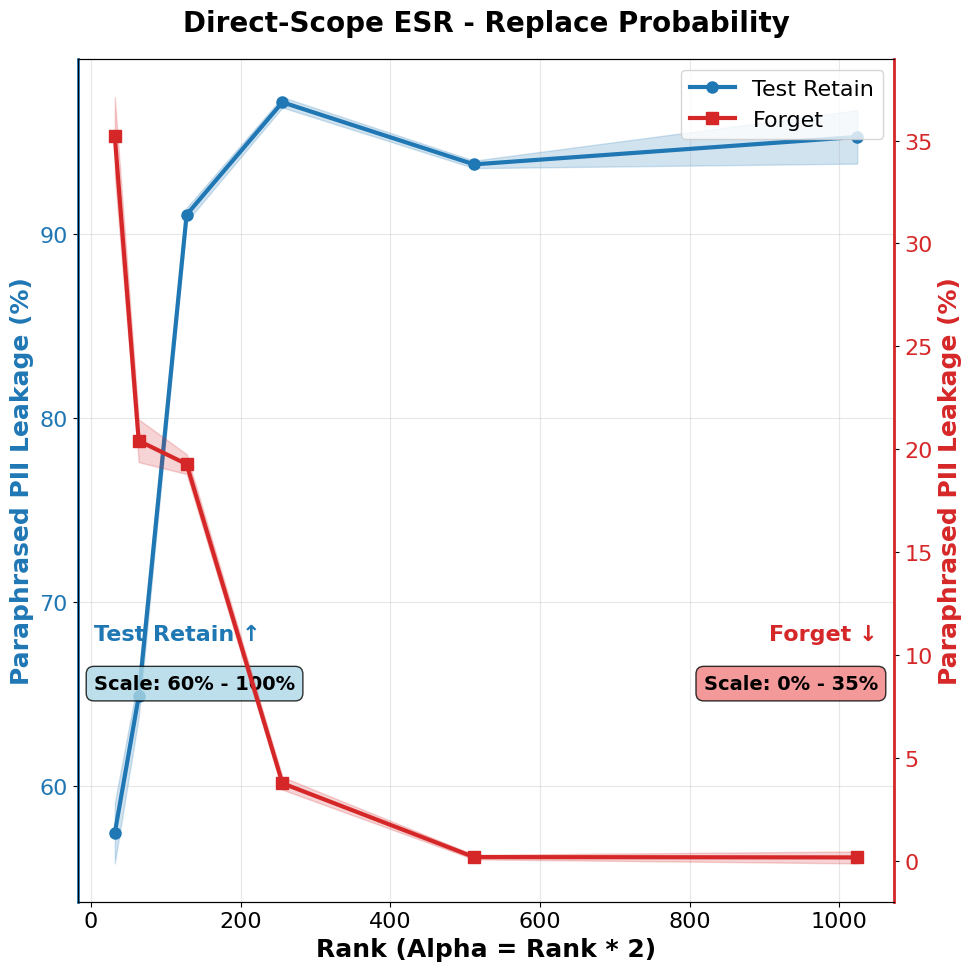

In [4]:
# Create the plot
fig_replace_prob = plot_replace_prob_analysis_dual(res_df, 
                                            title = f'Direct-Scope ESR - Replace Probability',
                                            score_col='rank',
                                            retain_col='exact_retain_score', 
                                            forget_col='exact_forget_score', 
                                            forget_scale = [0,35],
                                            retain_scale = [60, 100]
                                           )
plt.show()

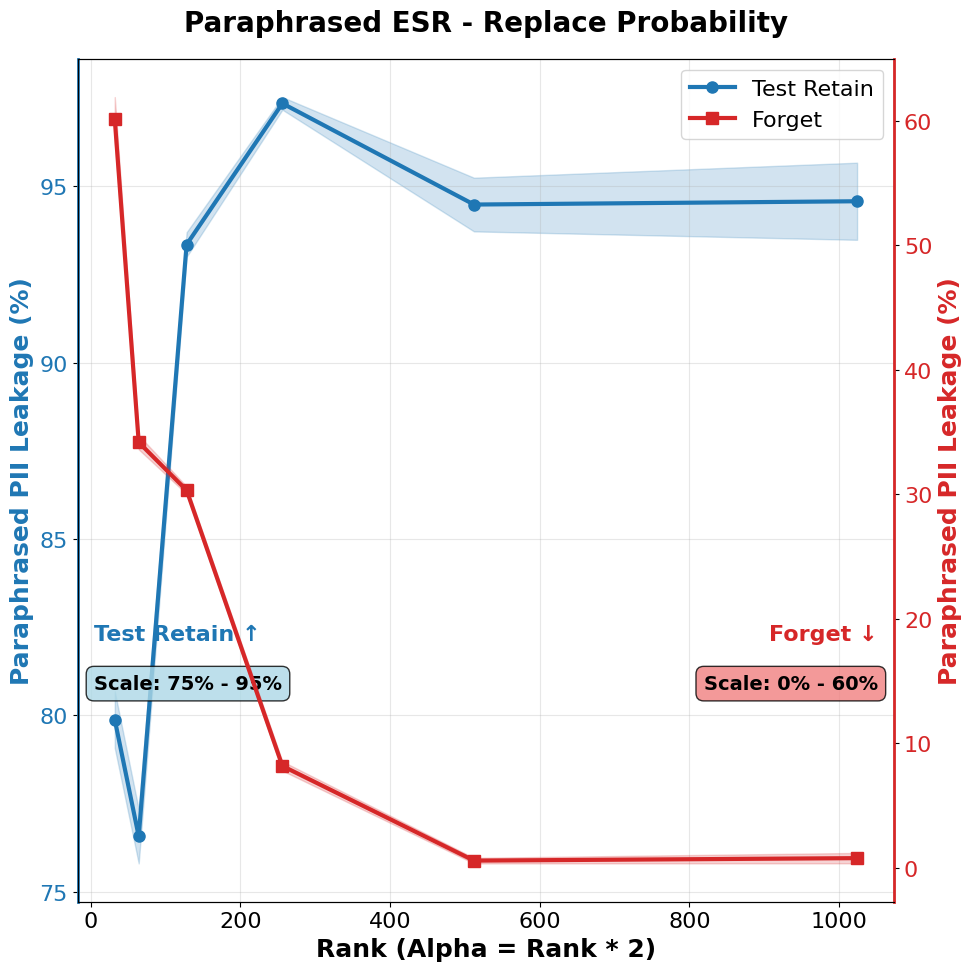

In [5]:
# Create the plot
fig_replace_prob = plot_replace_prob_analysis_dual(res_df, 
                                            title = f'Paraphrased ESR - Replace Probability',
                                            score_col='rank',
                                            retain_col='para_scores_retain_exact', 
                                            forget_col='para_scores_forget_exact', 
                                           forget_scale = [0,60],
                                           retain_scale = [75, 95]
                                           )
plt.show()

In [7]:
########## read 10 runs

experiment_path = '/projects/0/hpmlprjs/LLM/danp/UGBench/experiment/PII/llama3.1-8b/forget10/_AllExperiments/PIIAnalysis/Reruns'
run_nums = [1,2,3,4,5,6,7,8,9,10]

def process_extraction_results(full_path):
    extract_path = full_path.replace('eval.csv', 'extraction_attack.json')
    with open(extract_path, 'r') as file:
        extraction_results = json.load(file)

    valid_keys = []
    for k in extraction_results.keys():
        if ('pii_extraction_leakage_rate' in k) and ('forget' in k or 'test_retain' in k) and ('partial' not in k):
            k = k.replace('test_retain', 'retain')
            valid_keys.append(k)        

    num_extraction_results = {k: extraction_results[k] for k in valid_keys} 
    new_df = pd.DataFrame([num_extraction_results])

    return new_df


def load_experiment_results(experiment_path, run_nums):
    results = []
    for in_text in [True]:
        for run_num in run_nums:
            P = 1 if in_text else 1.2
            dir_path = f'llama3.1-8b_E8_B16_C0.1_P_{P}_token_level{in_text}_run{run_num}_test/eval_results/eval.csv'
            try:
                df = pd.read_csv(experiment_path + '/' + dir_path)
       
                df['run_num'] = run_num
              
                
                # Also remove PII columns as before
                valid_cols = [col for col in df.columns if not col.startswith('PII')]
                df = df[valid_cols]
                
                # Get extraction results and add them to the dataframe
                full_eval_path = experiment_path + '/' + dir_path
          
                
                results.append(df)
            except FileNotFoundError:
                print(f"File not found: {dir_path}")
    return pd.concat(results, ignore_index=True)

fullft_df = load_experiment_results(experiment_path, run_nums)
fullft_df['rank'] = 'full'
fullft_df = fullft_df.groupby('rank').mean(numeric_only=True).reset_index()


#### Load Results for Best-performing QLoRA

In [10]:
########## read 10 runs
import pandas as pd
import json

experiment_path = '/projects/0/hpmlprjs/LLM/danp/UGBench/experiment/PII/llama3.1-8b/forget10/_AllExperiments/LoRA'
run_nums = [1, 2, 3, 4, 5]
dir_path = f'LoRA_PII_llama3.1-8b_E8_B16_r32_a64_token_levelTrue_run1'


def load_experiment_results(experiment_path, run_nums):
    results = []
    for rank in [32, 1024]:

        for run_num in run_nums:

         
            dir_path = f'QLoRA_PII_llama3.1-8b_E8_B16_r{rank}_a{rank*2}_token_levelTrue_run{run_num}/eval_results/eval.csv'
            try:
                df = pd.read_csv(experiment_path + '/' + dir_path)
                method_name = "TLPerMU"
                df['rank'] = str(rank) + 'q' 
                df['run_num'] = run_num
              
                
                # Also remove PII columns as before
                valid_cols = [col for col in df.columns if not col.startswith('PII')]
                df = df[valid_cols]
                
                # Get extraction results and add them to the dataframe
                full_eval_path = experiment_path + '/' + dir_path
          
                
                results.append(df)
            except FileNotFoundError:
                print(f"File not found: {dir_path}")
    return pd.concat(results, ignore_index=True)

qres_df = load_experiment_results(experiment_path, run_nums)
qres_df = qres_df.groupby('rank').mean(numeric_only=True).drop(columns=['run_num']).reset_index()

#### Load Results for Best-performing PerMU

In [11]:
########## read 10 runs
import pandas as pd
import json

experiment_path = '/projects/0/hpmlprjs/LLM/danp/UGBench/experiment/PII/llama3.1-8b/forget10/_AllExperiments/LoRA'
run_nums = [1, 2, 3, 4, 5]
dir_path = f'LoRA_PII_llama3.1-8b_E8_B16_r32_a64_token_levelTrue_run1'


def load_experiment_results(experiment_path, run_nums):
    results = []
    for rank in [1024]:

        for run_num in run_nums:

         
            dir_path = f'LoRA_PII_llama3.1-8b_E8_B16_r{rank}_a{rank*2}_token_levelFalse_run{run_num}/eval_results/eval.csv'
            try:
                df = pd.read_csv(experiment_path + '/' + dir_path)
                method_name = "TLPerMU"
                df['rank'] = str(rank) + 'permu'
                df['run_num'] = run_num
              
                
                # Also remove PII columns as before
                valid_cols = [col for col in df.columns if not col.startswith('PII')]
                df = df[valid_cols]
                
                # Get extraction results and add them to the dataframe
                full_eval_path = experiment_path + '/' + dir_path
          
                
                results.append(df)
            except FileNotFoundError:
                print(f"File not found: {dir_path}")
    return pd.concat(results, ignore_index=True)

permu_res_df = load_experiment_results(experiment_path, run_nums)
permu_res_df = permu_res_df.groupby('rank').mean(numeric_only=True).drop(columns=['run_num']).reset_index()


In [12]:
permu_res_df

,rank,para_scores_forget_exact,para_scores_forget_partial_ratio,para_scores_forget_token_set_ratio,Prob. Forget Paraphrase,ROUGE Forget Paraphrase,Fluency Forget Paraphrase,Truth Ratio Forget Paraphrase,para_scores_retain_exact,para_scores_retain_partial_ratio,...,one_hop_scores_forget_pii,one_hop_scores_retain_pii,one_hop_scores_forget_name,one_hop_scores_retain_name,inverse_scores_forget_exact,inverse_scores_forget_partial_ratio,inverse_scores_forget_token_set_ratio,inverse_scores_retain_exact,inverse_scores_retain_partial_ratio,inverse_scores_retain_token_set_ratio
0,1024permu,0.002333,0.021667,0.003833,0.213342,0.335783,3.709995,0.5467,0.893467,0.935467,...,0.026415,0.602899,0.083019,0.428986,0.111,0.245,0.183,0.3216,0.344,0.3272


In [13]:
#group_df = pd.concat([group_df,qres_df,permu_res_df, fullft_df], ignore_index=True)
group_df = pd.concat([group_df,qres_df, fullft_df], ignore_index=True)

In [14]:
import numpy as np
from scipy.stats import hmean

def calculate_model_utility(df):
    """Calculate Model Utility as harmonic mean of all specified metrics."""
    
    utility_columns = [
        'ROUGE Retain', 'Prob. Retain', 'Truth Ratio Retain',
        'ROUGE Real Authors', 'Prob. Real Authors', 'Truth Ratio Real Authors',
        'Prob. Real World', 'ROUGE Real World', 'Truth Ratio Real World'
    ]
    
    existing_columns = [col for col in utility_columns if col in df.columns]
    df_copy = df.copy()
    
    # Ensure positive values for harmonic mean
    for col in existing_columns:
        df_copy[col] = np.maximum(df_copy[col], 1e-6)
    
    df_copy['Model Utility'] = df_copy[existing_columns].apply(lambda row: hmean(row.values), axis=1)
    return df_copy
group_df = calculate_model_utility(group_df)

In [15]:
group_df.rename(columns={'extraction_scores_forget_exact': 'Naive Forget ESR',
               'targetted_extraction_scores_forget_exact': 'Targeted Forget ESR',
               'extraction_scores_retain_exact': 'Naive Test Retain ESR',
               'targetted_extraction_scores_retain_exact': 'Targeted Test Retain ESR'},inplace=True)



group_df.rename(columns={'exact_forget_score': 'Direct Forget ESR',
               'inverse_scores_forget_exact': 'Inverse Forget ESR',
               'exact_retain_score': 'Direct Test Retain ESR',
               'inverse_scores_retain_exact': 'Inverse Test Retain ESR',
               'para_scores_retain_exact': 'Paraphrase Test Retain ESR',
               'para_scores_forget_exact': 'Paraphrase Forget ESR',
               'one_hop_scores_forget_pii': 'One Hop Forget ESR',
                'one_hop_scores_retain_pii': 'One Hop Test Retain ESR',
               },inplace=True)

In [16]:
group_df[['Direct Forget ESR', 'Paraphrase Forget ESR', 'One Hop Forget ESR', 'Inverse Forget ESR']] = group_df[['Direct Forget ESR', 'Paraphrase Forget ESR', 'One Hop Forget ESR', 'Inverse Forget ESR']].apply(lambda x: x * 100)

In [17]:
group_df[['rank','Direct Forget ESR', 'Paraphrase Forget ESR', 'One Hop Forget ESR', 'Inverse Forget ESR','Model Utility','Fluency Forget']].round(2)

,rank,Direct Forget ESR,Paraphrase Forget ESR,One Hop Forget ESR,Inverse Forget ESR,Model Utility,Fluency Forget
0,32,35.22,60.12,53.58,33.2,0.56,3.88
1,64,20.42,34.17,29.43,26.8,0.54,3.63
2,128,19.28,30.32,22.26,28.9,0.55,3.86
3,256,3.78,8.17,9.43,22.6,0.54,3.91
4,512,0.20,0.57,3.77,7.7,0.53,3.71
5,1024,0.18,0.77,2.64,5.8,0.55,3.72
6,1024q,10.70,13.12,20.75,24.9,0.56,3.87
7,32q,95.35,98.28,75.47,45.4,0.59,3.86
8,full,0.50,0.67,3.77,4.5,0.55,3.66


In [18]:
group_df[['rank','Direct Test Retain ESR', 'Paraphrase Test Retain ESR', 'One Hop Test Retain ESR', 'Inverse Test Retain ESR','Model Utility','Fluency Retain']].round(3)

,rank,Direct Test Retain ESR,Paraphrase Test Retain ESR,One Hop Test Retain ESR,Inverse Test Retain ESR,Model Utility,Fluency Retain
0,32,0.574,0.799,0.681,0.345,0.561,3.923
1,64,0.649,0.766,0.559,0.304,0.535,3.835
2,128,0.910,0.933,0.722,0.376,0.553,3.896
3,256,0.971,0.973,0.765,0.390,0.537,3.969
4,512,0.938,0.945,0.646,0.373,0.528,3.953
5,1024,0.953,0.946,0.551,0.310,0.550,3.982
6,1024q,0.957,0.961,0.670,0.378,0.564,3.963
7,32q,0.984,0.994,0.736,0.397,0.593,3.908
8,full,0.947,0.943,0.696,0.348,0.550,3.962
